In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from python_scripts.utilities import single_to_batch_results

# Merge all simulations to single results file

In [2]:
single_results_folder = "results/highd_simulations_pickle_new"
batch_results_path = "results/batch_results_new"

single_to_batch_results(single_results_folder, batch_results_path)

100%|██████████| 461/461 [04:46<00:00,  1.61it/s]


## Visualise all results

In [154]:
batch_results_path = "results/batch_results_new"
batch_results = pd.read_pickle(batch_results_path)
filtered_results = batch_results[batch_results.number_of_traffic < 6]

print_best = True
print_computational_times = True
plot_max_speed_reduction = True
plot_average_speed_reduction = True
plot_integrated_speed_reduction = True
plot_novel_baseline_max_scatter_filtered = True
plot_novel_baseline_avg_scatter_filtered = True
plot_novel_baseline_max_scatter = True
plot_novel_baseline_avg_scatter = True
plot_ntraffic_scatter = True
plot_ttc_scatter = True
plot_dhw_scatter = True

LABELSIZE = 12
TITLESIZE = 16
GAMMA = 0.35

print("The number of scenarios passing the filter: ", len(filtered_results.index))

The number of scenarios passing the filter:  118


In [155]:

if print_best:
    batch_results["improvement_over_baseline"] = batch_results["min_vel_novel"]-batch_results["min_vel_baseline"]
    best_result = batch_results[batch_results["improvement_over_baseline"] == batch_results["improvement_over_baseline"].max()]
    print("Biggest improvement: ", best_result["scenario_id"].values[0], " which reduced the slowdown by ", best_result["improvement_over_baseline"].values[0]*3.6, "km/h")
    print("Top 5 best improvements: ", batch_results.sort_values(by=['improvement_over_baseline'], ascending=False)["scenario_id"].values[:5])
    print("Selection of no improvements: ", batch_results.sort_values(by=['improvement_over_baseline'], ascending=True)["scenario_id"].values[:5])

Biggest improvement:  ZAM_HighD-51_1_T-1  which reduced the slowdown by  18.0 km/h
Top 5 best improvements:  ['ZAM_HighD-51_1_T-1' 'ZAM_HighD-16_2_T-1' 'ZAM_HighD-48_11_T-1'
 'ZAM_HighD-6_3_T-1' 'ZAM_HighD-2_1_T-1']
Selection of no improvements:  ['ZAM_HighD-36_4_T-1' 'ZAM_HighD-8_6_T-1' 'ZAM_HighD-34_2_T-1'
 'ZAM_HighD-43_1_T-1' 'ZAM_HighD-46_9_T-1']


In [156]:

if print_computational_times:
    print("The average computational time for the update step is: ", np.average(filtered_results["comp_time_update"]), " s")
    print("The average computational time for the prediction step is: ", np.average(filtered_results["comp_time_predict"]), " s")
    print("The median computational time for the update step is: ", np.median(filtered_results["comp_time_update"]), " s")
    print("The median computational time for the prediction step is: ", np.median(filtered_results["comp_time_predict"]), " s")

The average computational time for the update step is:  0.14600096067409726  s
The average computational time for the prediction step is:  2.143636638288688  s
The median computational time for the update step is:  0.12888330438043477  s
The median computational time for the prediction step is:  1.9819070967391301  s


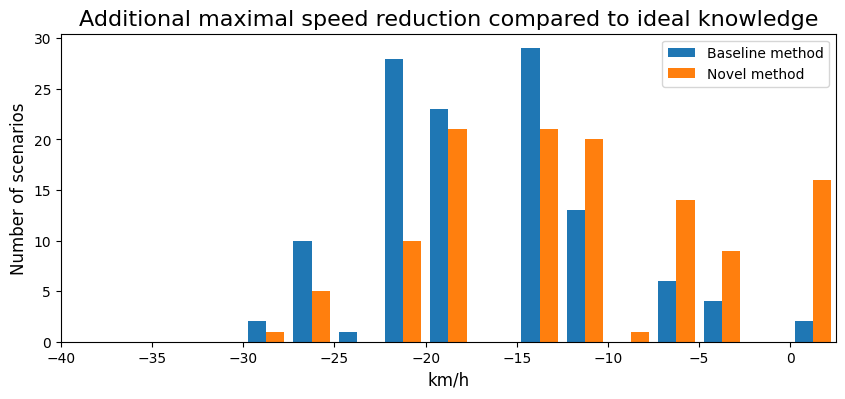

The average max speed reduction for the novel method is:  -11.941016949152543  km/h
The average max speed reduction for the baseline method is:  -16.669830508474575  km/h
The median max speed reduction for the novel method is:  -10.8  km/h
The median max speed reduction for the baseline method is:  -18.0  km/h


In [157]:

if plot_max_speed_reduction:
    fig = plt.figure(figsize=(10,4))
    plt.hist([(filtered_results["min_vel_baseline"] - filtered_results["min_vel_ideal"])*3.6,
              (filtered_results["min_vel_novel"] - filtered_results["min_vel_ideal"])*3.6], 
             np.arange(-40.0001, 3,2.5),
             label = ["novel method", "baseline method"])
    plt.title("Additional maximal speed reduction compared to ideal knowledge", fontsize=TITLESIZE)
    plt.xlabel("km/h", fontsize=LABELSIZE)
    plt.ylabel("Number of scenarios", fontsize=LABELSIZE)
    plt.legend(["Baseline method", "Novel method"])
    plt.xlim([-40,2.5])
    plt.show()
    print("The average max speed reduction for the novel method is: ", np.average((filtered_results["min_vel_novel"] - filtered_results["min_vel_ideal"])*3.6), " km/h")
    print("The average max speed reduction for the baseline method is: ", np.average((filtered_results["min_vel_baseline"] - filtered_results["min_vel_ideal"])*3.6), " km/h")
    print("The median max speed reduction for the novel method is: ", np.median((filtered_results["min_vel_novel"] - filtered_results["min_vel_ideal"])*3.6), " km/h")
    print("The median max speed reduction for the baseline method is: ", np.median((filtered_results["min_vel_baseline"] - filtered_results["min_vel_ideal"])*3.6), " km/h")

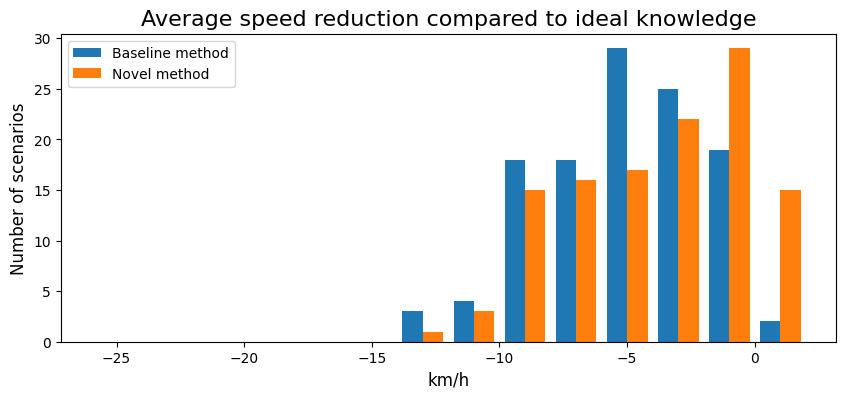

The average average speed reduction for the novel method is:  -3.9987720392116546  km/h
The average average speed reduction for the baseline method is:  -5.1119989305050275  km/h
The median average speed reduction for the novel method is:  -3.2975438892794324  km/h
The median average speed reduction for the baseline method is:  -4.415999999999993  km/h


In [158]:

if plot_average_speed_reduction:
    fig = plt.figure(figsize=(10,4))
    plt.hist([(filtered_results["avg_vel_baseline"] - filtered_results["avg_vel_ideal"])*3.6,
              (filtered_results["avg_vel_novel"] - filtered_results["avg_vel_ideal"])*3.6], 
             np.arange(-26.0001, 2.9999,2),
             label = ["Baseline method", "Novel method"])
    plt.title("Average speed reduction compared to ideal knowledge", fontsize=TITLESIZE)
    plt.xlabel("km/h", fontsize=LABELSIZE)
    plt.ylabel("Number of scenarios", fontsize=LABELSIZE)
    plt.legend(["Baseline method", "Novel method"])
    plt.show()
    print("The average average speed reduction for the novel method is: ", np.average((filtered_results["avg_vel_novel"] - filtered_results["avg_vel_ideal"])*3.6), " km/h")
    print("The average average speed reduction for the baseline method is: ", np.average((filtered_results["avg_vel_baseline"] - filtered_results["avg_vel_ideal"])*3.6), " km/h")
    print("The median average speed reduction for the novel method is: ", np.median((filtered_results["avg_vel_novel"] - filtered_results["avg_vel_ideal"])*3.6), " km/h")
    print("The median average speed reduction for the baseline method is: ", np.median((filtered_results["avg_vel_baseline"] - filtered_results["avg_vel_ideal"])*3.6), " km/h")

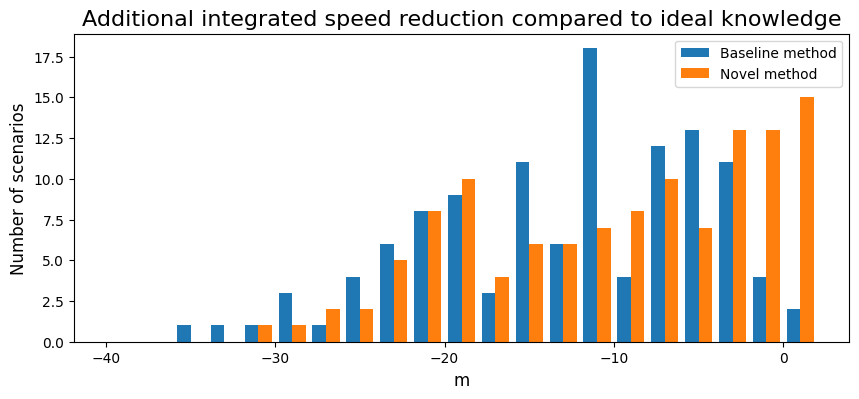

In [159]:

if plot_integrated_speed_reduction:
    fig = plt.figure(figsize=(10,4))
    plt.hist([filtered_results["integrated_vel_reduction_baseline"] - filtered_results["integrated_vel_reduction_ideal"],
              filtered_results["integrated_vel_reduction_novel"] - filtered_results["integrated_vel_reduction_ideal"]], 
             np.arange(-40.0001, 3.9999,2),
             label = ["novel method", "baseline method"])
    plt.title("Additional integrated speed reduction compared to ideal knowledge", fontsize=TITLESIZE)
    plt.xlabel("m", fontsize=LABELSIZE)
    plt.ylabel("Number of scenarios", fontsize=LABELSIZE)
    plt.legend(["Baseline method", "Novel method"])
    plt.show()

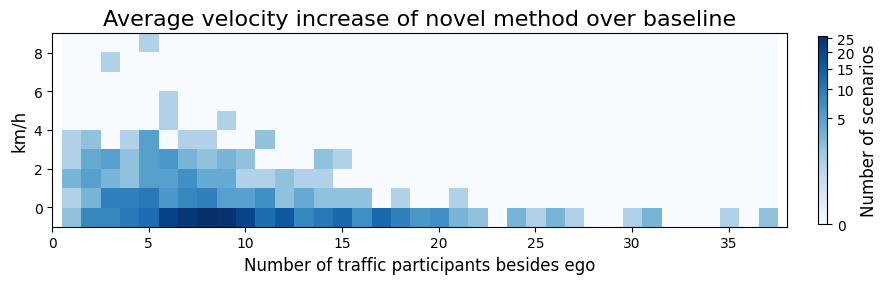

In [160]:

if plot_ntraffic_scatter:
    scatter_data = [batch_results["number_of_traffic"],
                    (batch_results["avg_vel_novel"] - batch_results["avg_vel_baseline"])*3.6]
    heatmap, xedges, yedges = np.histogram2d(scatter_data[0], scatter_data[1], range=[[0.5, 37.5],[-0.9999,9.0001]], bins=[37,10])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    fig = plt.figure(figsize=(10,6))
    plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.Blues, norm=colors.PowerNorm(gamma=GAMMA))
    plt.xlabel("Number of traffic participants besides ego", fontsize=LABELSIZE)
    plt.ylabel("km/h", fontsize=LABELSIZE)
    plt.xlim(0,38)
    plt.gca().set_aspect('equal')
    cbar = plt.colorbar(fraction=0.045*10/37, pad=0.04)
    cbar.ax.set_ylabel('Number of scenarios', fontsize=LABELSIZE)
    plt.title("Average velocity increase of novel method over baseline", fontsize=TITLESIZE)

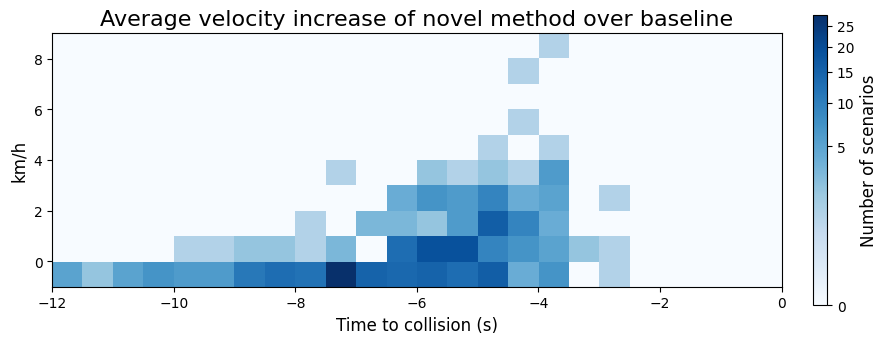

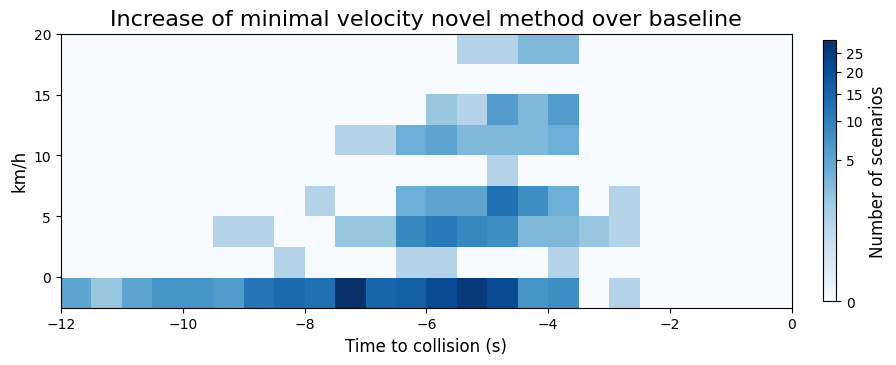

In [161]:

if plot_ttc_scatter:
    scatter_data = [batch_results["merge_ttc"],
                    (batch_results["avg_vel_novel"] - batch_results["avg_vel_baseline"])*3.6]
    heatmap, xedges, yedges = np.histogram2d(scatter_data[0], scatter_data[1], range=[[-12,0],[-0.9999,9.0001]], bins=[24,10])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    fig = plt.figure(figsize=(10,6))
    plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.Blues, norm=colors.PowerNorm(gamma=GAMMA))
    plt.xlabel("Time to collision (s)", fontsize=LABELSIZE)
    plt.ylabel("km/h", fontsize=LABELSIZE)
    plt.gca().set_aspect(10/24)
    cbar = plt.colorbar(fraction=0.045*10/24, pad=0.04)
    cbar.ax.set_ylabel('Number of scenarios', fontsize=LABELSIZE)
    plt.title("Average velocity increase of novel method over baseline", fontsize=TITLESIZE)

    scatter_data = [batch_results["merge_ttc"],
                    (batch_results["min_vel_novel"] - batch_results["min_vel_baseline"])*3.6]
    heatmap, xedges, yedges = np.histogram2d(scatter_data[0], scatter_data[1], range=[[-12,0],[-2.49999,20.0001]], bins=[24,9])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    fig = plt.figure(figsize=(10,6))
    plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.Blues, norm=colors.PowerNorm(gamma=GAMMA))
    plt.xlabel("Time to collision (s)", fontsize=LABELSIZE)
    plt.ylabel("km/h", fontsize=LABELSIZE)
    #plt.ylim([-2,20])
    plt.gca().set_aspect(0.2)
    cbar = plt.colorbar(fraction=0.045*9/24, pad=0.04)
    cbar.ax.set_ylabel('Number of scenarios', fontsize=LABELSIZE)
    plt.title("Increase of minimal velocity novel method over baseline", fontsize=TITLESIZE)

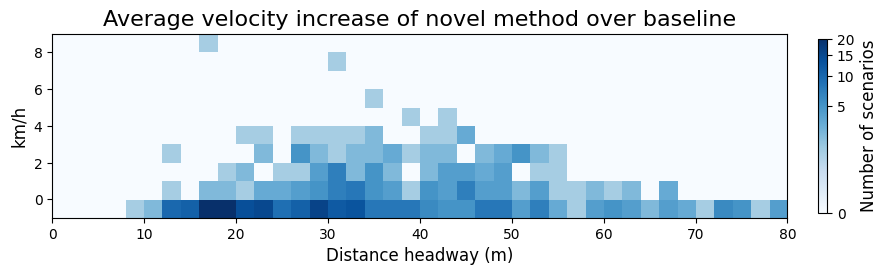

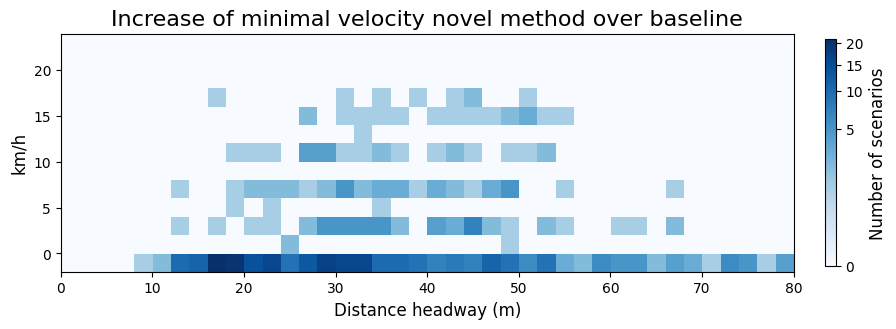

In [162]:

if plot_dhw_scatter:
    scatter_data = [batch_results["merge_dhw"],
                    (batch_results["avg_vel_novel"] - batch_results["avg_vel_baseline"])*3.6]
    heatmap, xedges, yedges = np.histogram2d(scatter_data[0], scatter_data[1], range=[[0,80],[-0.9999,9.0001]], bins=[40,10])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    fig = plt.figure(figsize=(10,6))
    plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.Blues, norm=colors.PowerNorm(gamma=GAMMA))
    plt.xlabel("Distance headway (m)", fontsize=LABELSIZE)
    plt.ylabel("km/h", fontsize=LABELSIZE)
    plt.gca().set_aspect(2)
    cbar = plt.colorbar(fraction=0.045*10/40, pad=0.04)
    cbar.ax.set_ylabel('Number of scenarios', fontsize=LABELSIZE)
    plt.title("Average velocity increase of novel method over baseline", fontsize=TITLESIZE)

    scatter_data = [batch_results["merge_dhw"],
                    (batch_results["min_vel_novel"] - batch_results["min_vel_baseline"])*3.6]
    heatmap, xedges, yedges = np.histogram2d(scatter_data[0], scatter_data[1], range=[[0,80],[-1.9999,24.0001]], bins=[40,13])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    fig = plt.figure(figsize=(10,6))
    plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.Blues, norm=colors.PowerNorm(gamma=GAMMA))
    plt.xlabel("Distance headway (m)", fontsize=LABELSIZE)
    plt.ylabel("km/h", fontsize=LABELSIZE)
    plt.gca().set_aspect(1)
    cbar = plt.colorbar(fraction=0.045*13/40, pad=0.04)
    cbar.ax.set_ylabel('Number of scenarios', fontsize=LABELSIZE)
    plt.title("Increase of minimal velocity novel method over baseline", fontsize=TITLESIZE)

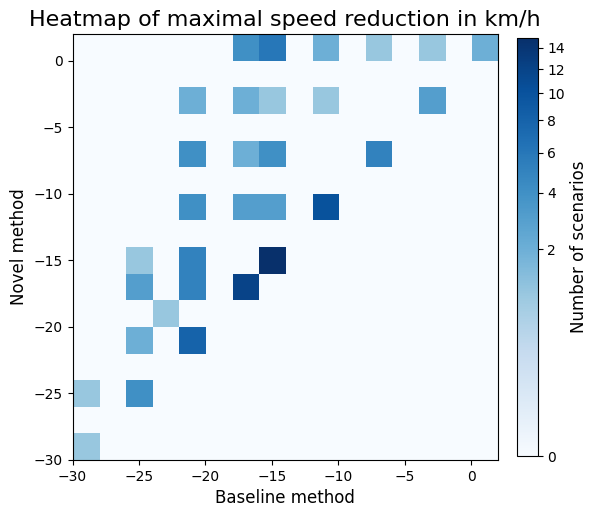

In [163]:

if plot_novel_baseline_max_scatter_filtered:
    scatter_data = [(filtered_results["min_vel_baseline"] - filtered_results["min_vel_ideal"])*3.6,
                    (filtered_results["min_vel_novel"] - filtered_results["min_vel_ideal"])*3.6]
    
    heatmap, xedges, yedges = np.histogram2d(scatter_data[0], scatter_data[1], range=[[-30, 2], [-30, 2]], bins=16)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    fig = plt.figure(figsize=(6,6))
    plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.Blues, norm=colors.PowerNorm(gamma=GAMMA))
    #plt.hexbin(scatter_data[0], scatter_data[1], gridsize=15, cmap=cm.Blues)
    plt.xlabel("Baseline method", fontsize=LABELSIZE)
    plt.ylabel("Novel method", fontsize=LABELSIZE)
    plt.gca().set_aspect('equal')
    cbar = plt.colorbar(fraction=0.045, pad=0.04)
    cbar.ax.set_ylabel('Number of scenarios', fontsize=LABELSIZE)
    plt.title("Heatmap of maximal speed reduction in km/h", fontsize=TITLESIZE)

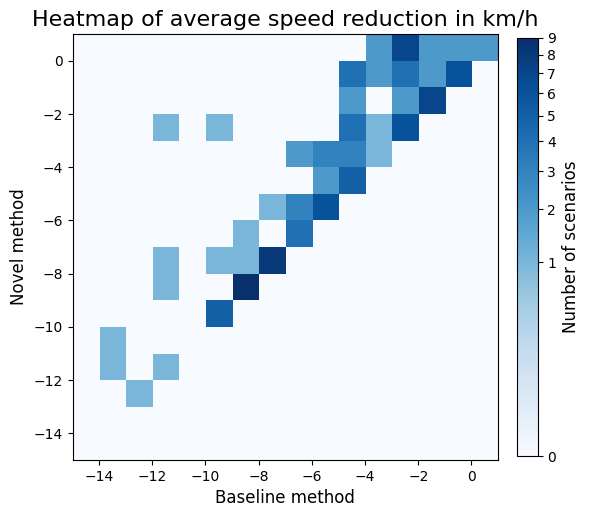

In [164]:

if plot_novel_baseline_avg_scatter_filtered:
    scatter_data = [(filtered_results["avg_vel_baseline"] - filtered_results["avg_vel_ideal"])*3.6,
                    (filtered_results["avg_vel_novel"] - filtered_results["avg_vel_ideal"])*3.6]
    
    heatmap, xedges, yedges = np.histogram2d(scatter_data[0], scatter_data[1], range=[[-15, 1], [-15, 1]], bins=16)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    fig = plt.figure(figsize=(6,6))
    plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.Blues, norm=colors.PowerNorm(gamma=GAMMA))
    #plt.hexbin(scatter_data[0], scatter_data[1], gridsize=15, cmap=cm.Blues)
    plt.xlabel("Baseline method", fontsize=LABELSIZE)
    plt.ylabel("Novel method", fontsize=LABELSIZE)
    plt.gca().set_aspect('equal')
    cbar = plt.colorbar(fraction=0.045, pad=0.04)
    cbar.ax.set_ylabel('Number of scenarios', fontsize=LABELSIZE)
    plt.title("Heatmap of average speed reduction in km/h", fontsize=TITLESIZE)

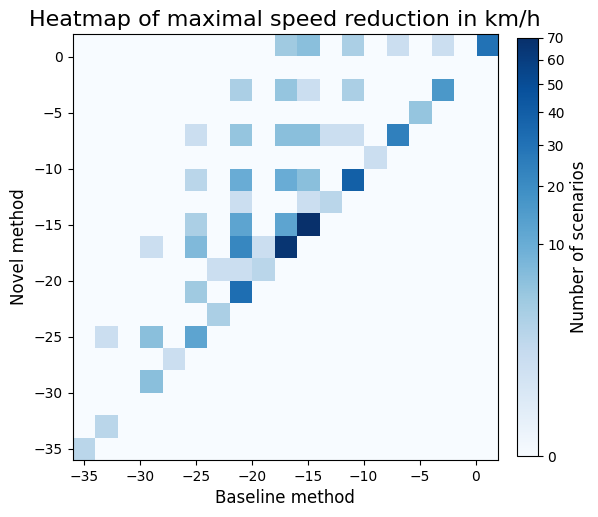

In [165]:

if plot_novel_baseline_max_scatter:
    scatter_data = [(batch_results["min_vel_baseline"] - batch_results["min_vel_ideal"])*3.6,
                    (batch_results["min_vel_novel"] - batch_results["min_vel_ideal"])*3.6]
    
    heatmap, xedges, yedges = np.histogram2d(scatter_data[0], scatter_data[1], range=[[-36, 2], [-36, 2]], bins=19)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    fig = plt.figure(figsize=(6,6))
    plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.Blues, norm=colors.PowerNorm(gamma=GAMMA))
    #plt.hexbin(scatter_data[0], scatter_data[1], gridsize=15, cmap=cm.Blues)
    plt.xlabel("Baseline method", fontsize=LABELSIZE)
    plt.ylabel("Novel method", fontsize=LABELSIZE)
    plt.gca().set_aspect('equal')
    cbar = plt.colorbar(fraction=0.045, pad=0.04)
    cbar.ax.set_ylabel('Number of scenarios', fontsize=LABELSIZE)
    plt.title("Heatmap of maximal speed reduction in km/h", fontsize=TITLESIZE)

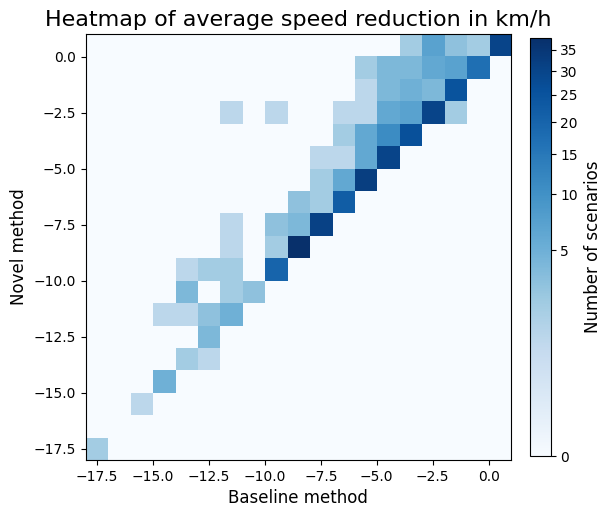

In [166]:

if plot_novel_baseline_avg_scatter:
    scatter_data = [(batch_results["avg_vel_baseline"] - batch_results["avg_vel_ideal"])*3.6,
                    (batch_results["avg_vel_novel"] - batch_results["avg_vel_ideal"])*3.6]
    
    heatmap, xedges, yedges = np.histogram2d(scatter_data[0], scatter_data[1], range=[[-18, 1], [-18, 1]], bins=19)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    fig = plt.figure(figsize=(6,6))
    plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.Blues, norm=colors.PowerNorm(gamma=GAMMA))
    #plt.hexbin(scatter_data[0], scatter_data[1], gridsize=15, cmap=cm.Blues)
    plt.xlabel("Baseline method", fontsize=LABELSIZE)
    plt.ylabel("Novel method", fontsize=LABELSIZE)
    plt.gca().set_aspect('equal')
    cbar = plt.colorbar(fraction=0.045, pad=0.04)
    cbar.ax.set_ylabel('Number of scenarios', fontsize=LABELSIZE)
    plt.title("Heatmap of average speed reduction in km/h", fontsize=TITLESIZE)